In [ ]:
from rtmag.process.download.find_harp import find_ar

In [ ]:
d = "2024-05-09 02:00:00"
ar, img = find_ar(d, show_image=True)
print(ar)

    NOAA_AR  HARPNUM
0     13663    11142
1     13664    11149
2         0    11150
3     13666    11152
4     13665    11159
5     13667    11170
6         0    11173
7     13670    11178
8         0    11182
9         0    11186
10        0    11187
11        0    11189
12    13672    11190
13    13679    11192
14        0    11194
15        0    11195


In [ ]:
from IPython.display import Image

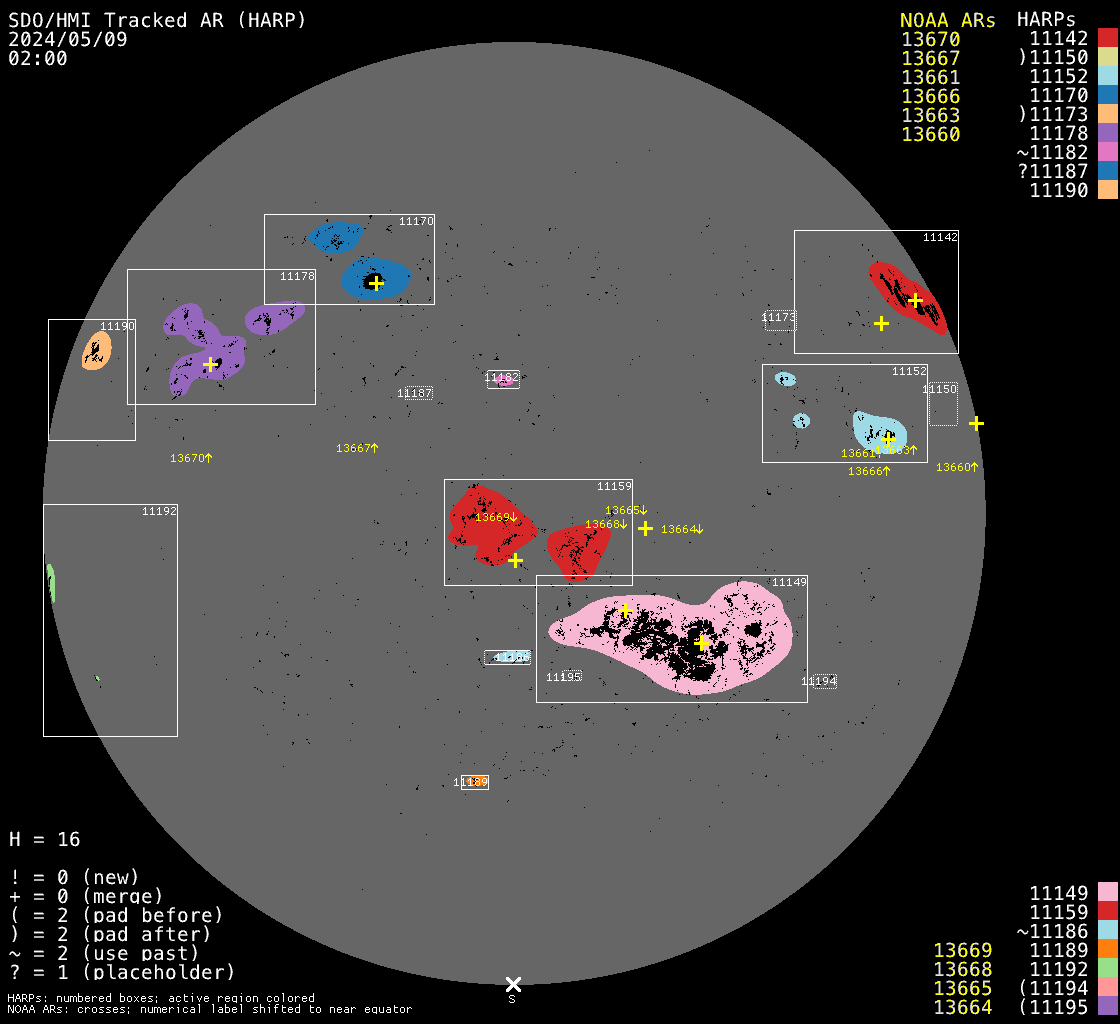

In [ ]:
Image(img)

In [ ]:
harpnum = 11149
noaanum = ar[ar['HARPNUM'] == harpnum]['NOAA_AR'].item()
print(noaanum)

13664


In [ ]:
from rtmag.process.download.dl_map import get_sharp_map

In [ ]:
hmi_map, hmi_data = get_sharp_map(d, harpnum)

T_REC:  2024.05.09_02:00:00_TAI


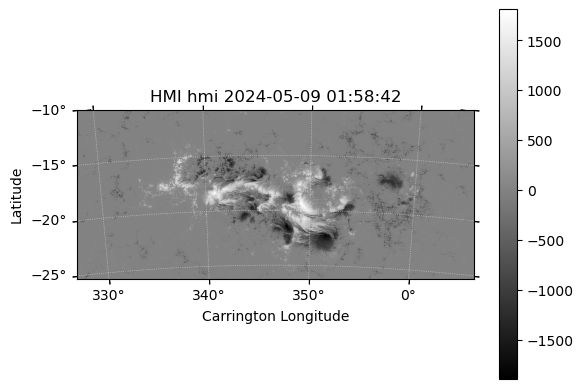

In [ ]:
hmi_map.peek()

In [ ]:
hmi_data.shape

(1202, 513, 3)

In [ ]:
from rtmag.process.paper.hmi_to_input import get_input

In [ ]:
nx = 512
ny = 256

model_input, x, y, z, dx, dy, dz = get_input(hmi_data, nx, ny)
model_input.shape

dx = 0.8565051313650011 Mm
dy = 0.7317077289490391 Mm
dz = 0.7317077289490391 Mm


(1, 1, 256, 512, 3)

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
meta_path = "pretrained/isee/best_model.pt"

In [ ]:
from rtmag.process.paper.load import MyModel

mm = MyModel(meta_path, device=device)

Model loaded from epoch 39


In [ ]:
b = mm.get_pred_from_numpy(model_input)
b.shape

b_norm = 2500 G
cuda:0
0.55780029296875 seconds


(512, 256, 256, 3)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
bottom = b[:, :, 0, 2]

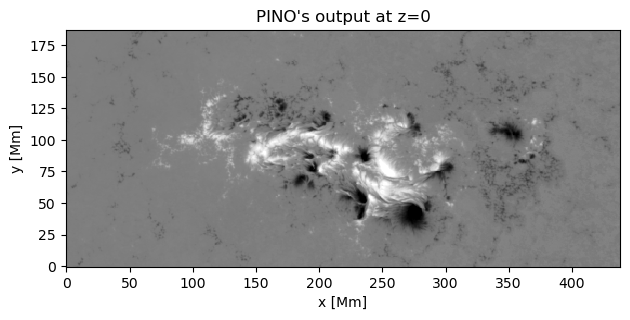

In [ ]:
fig, ax = plt.subplots()
ax.pcolormesh(x, y, bottom.T, cmap='gray', vmin=-2000, vmax=2000)
ax.set_xlabel('x [Mm]')
ax.set_ylabel('y [Mm]')
ax.set_aspect('equal')
ax.set_title("PINO's output at z=0")
plt.tight_layout()
plt.show()

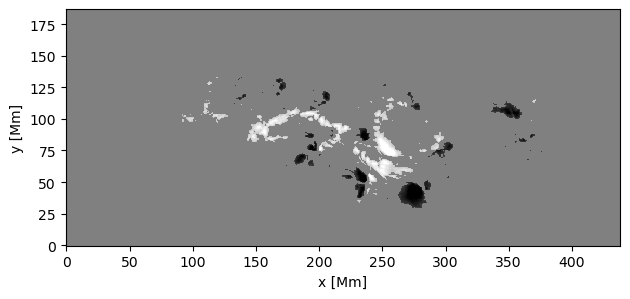

In [ ]:
mask = np.abs(bottom) > 1000
fig, ax = plt.subplots()
ax.pcolormesh(x, y, (bottom*mask).T, cmap='gray', vmin=-2000, vmax=2000)
ax.set_xlabel('x [Mm]')
ax.set_ylabel('y [Mm]')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

In [ ]:
stride = 20
seeds = np.stack([np.where(mask == True)[0], 
                  np.where(mask == True)[1], 
                  np.zeros_like(np.where(mask == True)[0])], axis=1)
seeds = seeds[::stride]
seeds.shape

(231, 3)

In [ ]:
from streamtracer import StreamTracer, VectorGrid

In [ ]:
nsteps = 10000
step_size = 0.1
grid_spacing = [1, 1, 1]

grid = VectorGrid(b.astype(np.float64), grid_spacing)
tracer = StreamTracer(nsteps, step_size)
tracer_xs = []
tracer.trace(seeds, grid)
tracer_xs.append(tracer.xs)
tracer_xs = [item for sublist in tracer_xs for item in sublist]

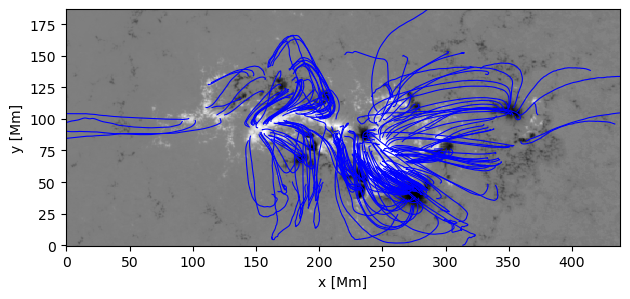

In [ ]:
fig, ax = plt.subplots()
ax.pcolormesh(x, y, bottom.T, cmap='gray', vmin=-2000, vmax=2000)
ax.set_xlabel('x [Mm]')
ax.set_ylabel('y [Mm]')
ax.set_aspect('equal')
for i, xl in enumerate(tracer_xs):
    assert seeds[i] in xl 
    ax.plot(xl[:,0]*dx+x[0], xl[:,1]*dy+y[0], color='blue', linewidth=0.8)
plt.tight_layout()
plt.show()

In [ ]:
import pyvista as pv

In [ ]:
xv, yv, zv = np.meshgrid(x, y, z, indexing='ij')
mesh = pv.StructuredGrid(xv, yv, zv)
bx, by, bz = b[..., 0], b[..., 1], b[..., 2]
vectors = np.stack([bx, by, bz], axis=-1).transpose(2, 1, 0, 3).reshape(-1, 3)
mesh['vector'] = vectors
mesh.active_vectors_name = 'vector'
mesh

StructuredGrid (0x134905972e0)
  N Cells:      33227775
  N Points:     33554432
  X Bounds:     0.000e+00, 4.377e+02
  Y Bounds:     0.000e+00, 1.866e+02
  Z Bounds:     0.000e+00, 1.866e+02
  Dimensions:   512, 256, 256
  N Arrays:     1

In [ ]:
xx, yy = np.meshgrid(x, y, indexing='ij')
seeds_xs = np.stack([xx[seeds[:, 0], seeds[:, 1]], 
                     yy[seeds[:, 0], seeds[:, 1]], 
                     np.zeros_like(seeds[:, 0])], axis=1)
seeds_xs.shape

(231, 3)

In [ ]:
pv.global_theme.notebook = True
pv.global_theme.jupyter_backend = 'static'
# pv.global_theme.jupyter_backend = 'trame'

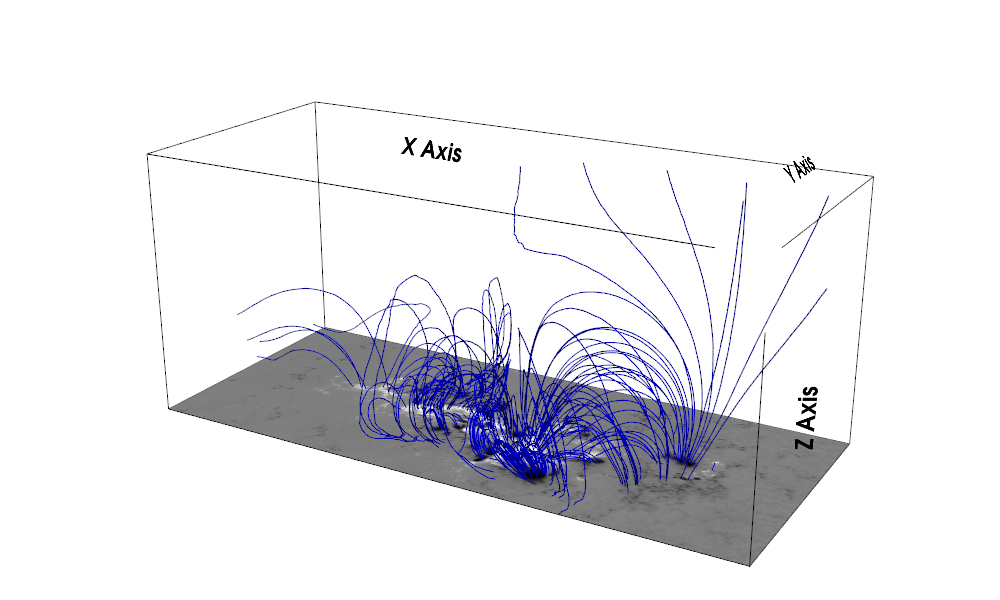

In [ ]:
p = pv.Plotter(window_size=(1000, 600))

p.show_bounds(
    grid='front',
    show_xlabels=False,
    show_ylabels=False,
    show_zlabels=False,
)
p.add_mesh(mesh.outline(), color='k')

seed = pv.PolyData(seeds_xs)
strl = mesh.streamlines_from_source(seed, vectors='vector', integration_direction='both',
                                    max_time=10000, initial_step_length=0.1)
p.add_mesh(strl.tube(radius=0.4), color='blue')

bottom_subset = mesh.extract_subset((0, nx-1, 0, ny-1, 0, 0)).extract_surface()
p.add_mesh(bottom_subset, cmap='gray', scalars='vector', component=2, clim=(-2000, 2000), 
           lighting=False, show_scalar_bar=False)

p.camera_position = "xy"
p.camera.roll = -30
p.camera.elevation = -70
p.camera.zoom(1.3)
p.show()

In [ ]:
from rtmag.process.download.dl_map import get_aia_map

In [ ]:
import warnings; warnings.filterwarnings('ignore')

In [ ]:
aia94_map = get_aia_map(d, wavelength=94)
aia131_map = get_aia_map(d, wavelength=131)
aia171_map = get_aia_map(d, wavelength=171)
aia193_map = get_aia_map(d, wavelength=193)
aia211_map = get_aia_map(d, wavelength=211)
aia304_map = get_aia_map(d, wavelength=304)
aia335_map = get_aia_map(d, wavelength=335)

T_REC:  2024-05-09T01:59:59Z
T_REC:  2024-05-09T01:59:59Z
T_REC:  2024-05-09T01:59:59Z
T_REC:  2024-05-09T01:59:59Z
T_REC:  2024-05-09T01:59:59Z
T_REC:  2024-05-09T01:59:59Z
T_REC:  2024-05-09T01:59:59Z


In [ ]:
import astropy.units as u

In [ ]:
aia94_map_repro = aia94_map.reproject_to(hmi_map.wcs)
aia94_map_repro = aia94_map_repro.resample([nx, ny] * u.pixel)

aia131_map_repro = aia131_map.reproject_to(hmi_map.wcs)
aia131_map_repro = aia131_map_repro.resample([nx, ny] * u.pixel)

aia171_map_repro = aia171_map.reproject_to(hmi_map.wcs)
aia171_map_repro = aia171_map_repro.resample([nx, ny] * u.pixel)

aia193_map_repro = aia193_map.reproject_to(hmi_map.wcs)
aia193_map_repro = aia193_map_repro.resample([nx, ny] * u.pixel)

aia211_map_repro = aia211_map.reproject_to(hmi_map.wcs)
aia211_map_repro = aia211_map_repro.resample([nx, ny] * u.pixel)

aia304_map_repro = aia304_map.reproject_to(hmi_map.wcs)
aia304_map_repro = aia304_map_repro.resample([nx, ny] * u.pixel)

aia335_map_repro = aia335_map.reproject_to(hmi_map.wcs)
aia335_map_repro = aia335_map_repro.resample([nx, ny] * u.pixel)

2025-02-07 14:59:25 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-02-07 14:59:26 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-02-07 14:59:26 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-02-07 14:59:27 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-02-07 14:59:27 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-02-07 14:59:28 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-02-07 14:59:28 - reproject.common - INFO: Calling _reproject_full in non-dask mode


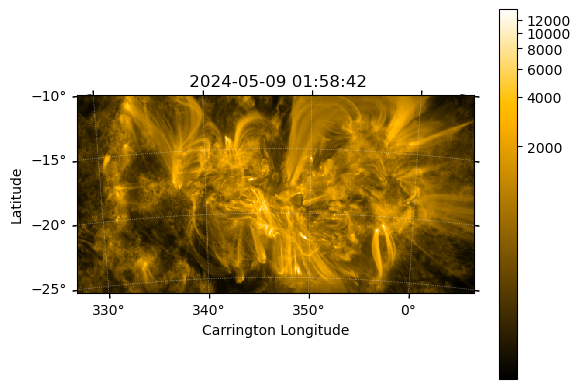

In [ ]:
aia171_map_repro.peek()

In [ ]:
from rtmag.process.paper.utils import get_j_map_Mm

In [ ]:
j_map, jz_btm = get_j_map_Mm(b, dx, dy, dz)

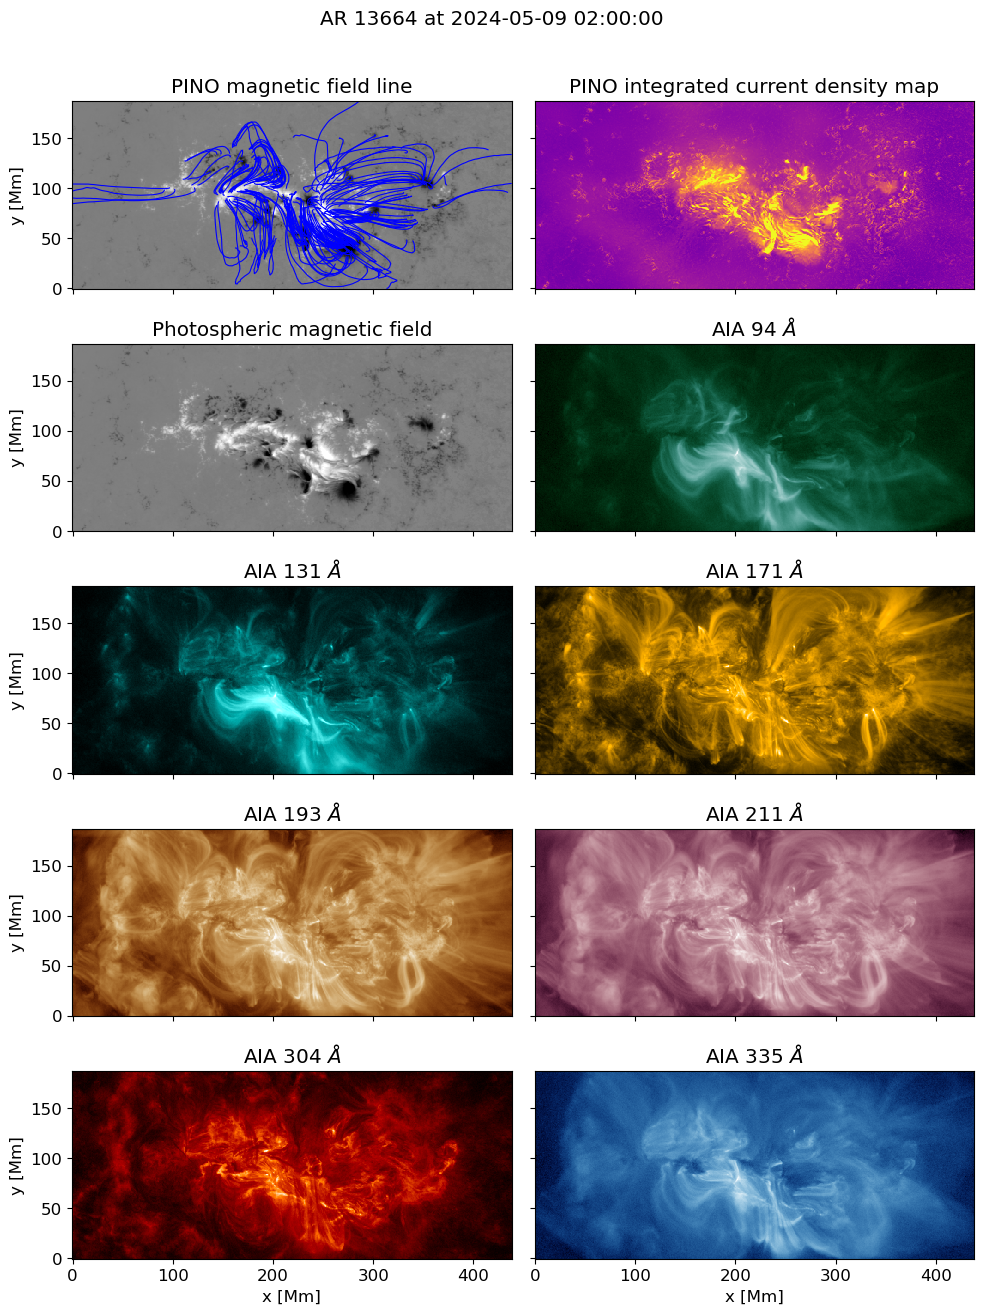

In [ ]:
plt.rcParams['font.size'] = 12
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 13), sharex=True, sharey=True)
axes = axes.flatten()

ax = axes[0]
ax.pcolormesh(x, y, bottom.T, cmap='gray', vmin=-2000, vmax=2000)
# ax.set_xlabel('x [Mm]')
ax.set_ylabel('y [Mm]')
ax.set_aspect('equal')
for i, xl in enumerate(tracer_xs):
    assert seeds[i] in xl 
    ax.plot(xl[:,0]*dx+x[0], xl[:,1]*dy+y[0], color='blue', linewidth=0.8)
ax.set_title("PINO magnetic field line")

ax = axes[1]
ax.pcolormesh(x, y, j_map.T, cmap='plasma',  vmin=0, vmax=2000)
# ax.set_xlabel('x [Mm]')
# ax.set_ylabel('y [Mm]')
ax.set_aspect('equal')
ax.set_title("PINO integrated current density map")

ax = axes[2]
ax.pcolormesh(x, y, bottom.T, cmap='gray', vmin=-2000, vmax=2000)
# ax.set_xlabel('x [Mm]')
ax.set_ylabel('y [Mm]')
ax.set_aspect('equal')
ax.set_title("Photospheric magnetic field")

ax = axes[3]
ax.pcolormesh(x, y, aia94_map_repro.data, 
              norm = aia94_map_repro.plot_settings['norm'],
              cmap = aia94_map_repro.plot_settings['cmap'],) 
# ax.set_xlabel('x [Mm]')
# ax.set_ylabel('y [Mm]')
ax.set_aspect('equal')
ax.set_title("AIA 94 $\AA$")

ax = axes[4]
ax.pcolormesh(x, y, aia131_map_repro.data, 
              norm = aia131_map_repro.plot_settings['norm'],
              cmap = aia131_map_repro.plot_settings['cmap'],) 
# ax.set_xlabel('x [Mm]')
ax.set_ylabel('y [Mm]')
ax.set_aspect('equal')
ax.set_title("AIA 131 $\AA$")

ax = axes[5]
ax.pcolormesh(x, y, aia171_map_repro.data, 
              norm = aia171_map_repro.plot_settings['norm'],
              cmap = aia171_map_repro.plot_settings['cmap'],)
# ax.set_xlabel('x [Mm]')
# ax.set_ylabel('y [Mm]')
ax.set_aspect('equal')
ax.set_title("AIA 171 $\AA$")

ax = axes[6]
ax.pcolormesh(x, y, aia193_map_repro.data, 
              norm = aia193_map_repro.plot_settings['norm'],
              cmap = aia193_map_repro.plot_settings['cmap'],)
# ax.set_xlabel('x [Mm]')
ax.set_ylabel('y [Mm]')
ax.set_aspect('equal')
ax.set_title("AIA 193 $\AA$")

ax = axes[7]
ax.pcolormesh(x, y, aia211_map_repro.data, 
              norm = aia211_map_repro.plot_settings['norm'],
              cmap = aia211_map_repro.plot_settings['cmap'],)
# ax.set_xlabel('x [Mm]')
# ax.set_ylabel('y [Mm]')
ax.set_aspect('equal')
ax.set_title("AIA 211 $\AA$")

ax = axes[8]
ax.pcolormesh(x, y, aia304_map_repro.data, 
              norm = aia304_map_repro.plot_settings['norm'],
              cmap = aia304_map_repro.plot_settings['cmap'],)
ax.set_xlabel('x [Mm]')
ax.set_ylabel('y [Mm]')
ax.set_aspect('equal')
ax.set_title("AIA 304 $\AA$")

ax = axes[9]
ax.pcolormesh(x, y, aia335_map_repro.data, 
              norm = aia335_map_repro.plot_settings['norm'],
              cmap = aia335_map_repro.plot_settings['cmap'],)
ax.set_xlabel('x [Mm]')
# ax.set_ylabel('y [Mm]')
ax.set_aspect('equal')
ax.set_title("AIA 335 $\AA$")

fig.suptitle(f"AR {noaanum} at {d}", y=1.01)
plt.tight_layout()
plt.show()

In [ ]:
fl_cmap = plt.get_cmap('rainbow')
fl_norm = plt.Normalize(vmin=0, vmax=30)
values = np.abs(jz_btm.T[seeds[:, 0], seeds[:, 1]])

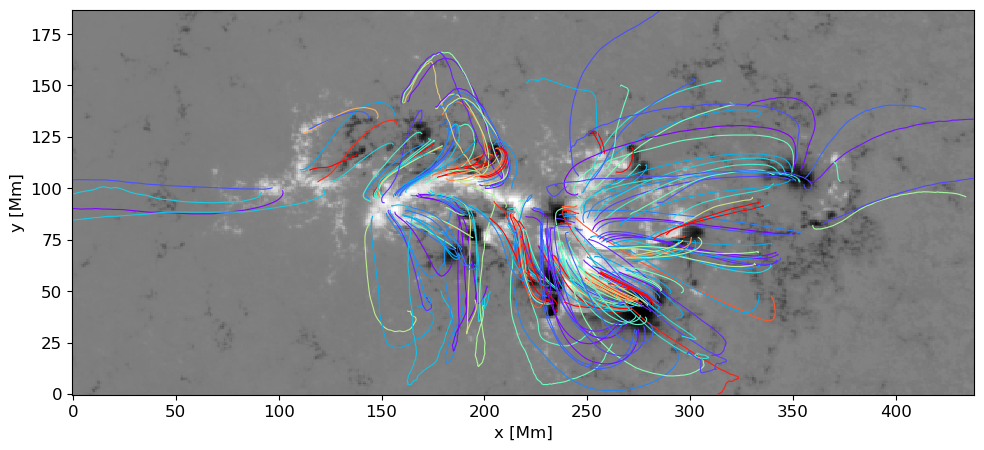

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 6))
ax.pcolormesh(x, y, bottom.T, cmap='gray', vmin=-2000, vmax=2000)
ax.set_xlabel('x [Mm]')
ax.set_ylabel('y [Mm]')
ax.set_aspect('equal')
colors = fl_cmap(fl_norm(values))
for i, xl in enumerate(tracer_xs):
    assert seeds[i] in xl 
    ax.plot(xl[:,0]*dx+x[0], xl[:,1]*dy+y[0], color=colors[i], linewidth=0.8)

plt.tight_layout()
plt.show()